# Hackathon

Some utilities

## Import Utils

In [1]:
!pip install keras
!pip install tables

    100% |################################| 337kB 3.1MB/s ta 0:00:011
    100% |################################| 256kB 3.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 4.6MB 322kB/s eta 0:00:01
    100% |################################| 399kB 3.7MB/s eta 0:00:01
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import keras
from keras.metrics import top_k_categorical_accuracy
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PATH_DATA = '/notebooks/data/sampled_7classes.h5'
PATH_PREDICT_WITHOUT_GT = '/notebooks/data/pred_students/pred_from_half/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = '/notebooks/ChallengeHacka/pred_eighties_from_half_1_gr6.csv'
# PATH_PREDICT_WITH_GT = '/pred_teachers/pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [4]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [5]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idx = idxs[b*batch_size]
            X = f['S2'][batch_idx:batch_idx+batch_size, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idx:batch_idx+batch_size, :]
            for i in range(len(Y)) :
                a = Y[i]
                if a < 4:
                    Y[i] -= 1
                elif a == 5:
                    Y[i] = 3
                elif a == 10:
                    Y[i] = 4
                elif a == 12:
                    Y[i] = 5
                elif a == 19:
                    Y[i] = 6
                else : 
                    print('value class out of range : %d ' %a)
                            
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 7)

In [6]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

print(len(idxs))

1538375


In [7]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [8]:
print(train_batch_count, val_batch_count)

38460 9615


In [8]:
label = h5.File(PATH_DATA)['TOP_LANDCOVER']
images = h5.File(PATH_DATA)['S2']

[ 1.  2.  3.  5. 10. 12. 19.]
[367471 121980 226523 211065 106192 390788 114356]


<Container object of 7 artists>

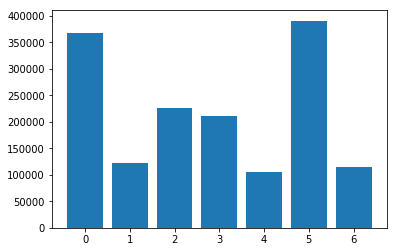

In [9]:
unique, counts = np.unique(label, return_counts=True)
# panda_prediction.describe()
print(unique)
print(counts)

plt.bar(np.arange(7), counts )

In [9]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Instanciation du model

In [10]:
input_shape = (16,16,4)

dropout_rate=0.5

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Fit

In [11]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy', top_3_accuracy ])

In [12]:
history = model.fit_generator(train_gen, steps_per_epoch=train_batch_count, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=1000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=38460, validation_data=<generator..., epochs=10, validation_steps=1000, verbose=1)`
  """Entry point for launching an IPython kernel.


Epoch 1/10
38460/38460 [==============================] - 1333s 35ms/step - loss: 1.4236 - acc: 0.4905 - top_3_accuracy: 0.8332 - val_loss: 1.5522 - val_acc: 0.4615 - val_top_3_accuracy: 0.8253
Epoch 2/10
38460/38460 [==============================] - 721s 19ms/step - loss: 1.3327 - acc: 0.5239 - top_3_accuracy: 0.8628 - val_loss: 1.4848 - val_acc: 0.4215 - val_top_3_accuracy: 0.8143
Epoch 3/10
38460/38460 [==============================] - 726s 19ms/step - loss: 1.3500 - acc: 0.5192 - top_3_accuracy: 0.8597 - val_loss: 1.2851 - val_acc: 0.5363 - val_top_3_accuracy: 0.8679
Epoch 4/10
38460/38460 [==============================] - 716s 19ms/step - loss: 1.3644 - acc: 0.5149 - top_3_accuracy: 0.8565 - val_loss: 1.2900 - val_acc: 0.5313 - val_top_3_accuracy: 0.8809
Epoch 5/10
38460/38460 [==============================] - 733s 19ms/step - loss: 1.3734 - acc: 0.5109 - top_3_accuracy: 0.8541 - val_loss: 1.3537 - val_acc: 0.5387 - val_top_3_accuracy: 0.8776
Epoch 6/10
38460/38460 [==========

In [ ]:

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit_generator(train_gen)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),steps_per_epoch=train_batch_count, epochs=5)

## Prediction routines

In order to submit a result here are some gits

In [13]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

In [14]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))

preds = np.argmax(prediction, axis = 1)

unique, counts = np.unique(preds, return_counts=True)
print(unique)
print(counts)

for i, p in enumerate(preds):
    if p == 0 :
        preds[i] = 1
    elif p == 1:
        preds[i] =  2
    elif p == 2:
        preds[i] =  3
    elif p == 3:
        preds[i] =  5
    elif p == 4:
        preds[i] =  10
    elif p == 5:
        preds[i] =  12
    elif p == 6:
        preds[i] =  19

panda_prediction = pd.DataFrame(preds)

panda_prediction

panda_prediction.columns = ['TOP_LANDCOVER']


241700
7554/7554 [==============================] - 46s 6ms/step
241700
[0 2 3 4 5 6]
[107630   1606   5230    164 126913    157]


In [ ]:
x = np.array([1, 2, 8, 10, 3, 2])

y = np.where(x == 2)[0]
y

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
# panda_prediction.describe()
print(unique)
print(counts)

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
# panda_prediction.describe()
print(unique)
print(counts)

In [15]:
panda_prediction.to_csv(PATH_SUBMIT, index_label = 'ID')

# Confusion matrix


In [17]:
prediction = model.predict_generator(val_gen, steps=get_batch_count(val_idxs, BATCH_SIZE), verbose=1)

9615/9615 [==============================] - 49s 5ms/step


In [18]:

def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idx = idxs[b*batch_size]
        Y = f['TOP_LANDCOVER'][batch_idx:batch_idx+batch_size, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_DATA, BATCH_SIZE, val_idxs)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

307680
307680
Confusion matrix, without normalization


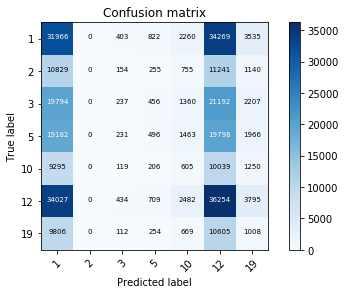

In [19]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes


y_true = np.argmax(gt, axis=1)
print(len(y_true))
y_pred = np.argmax(prediction, axis = 1)
print(len(y_pred))

for i, p in enumerate(y_pred):
    if p == 0 :
        y_pred[i] = 1
    elif p == 1:
        y_pred[i] =  2
    elif p == 2:
        y_pred[i] =  3
    elif p == 3:
        y_pred[i] =  5
    elif p == 4:
        y_pred[i] =  10
    elif p == 5:
        y_pred[i] =  12
    elif p == 6:
        y_pred[i] =  19
        
real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=False)

